# Redes Neurais Convolucionais (CNN)

### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
tf.compat.v1.disable_eager_execution()

### Exemplo simples

In [3]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg')
flower = load_sample_image('flower.jpg')
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

#### Cria dois fitros

In [4]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # linha vertical
filters[3, :, :, 1] = 1  # linha horizontal

#### Crie um gráfico com a entrada X mais uma camada convolucional aplicando os 2 filtros

In [5]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1, 2, 2, 1], padding='SAME')

with tf.compat.v1.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

#### Plots das imagens

In [6]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation='nearest')
    plt.axis('off')

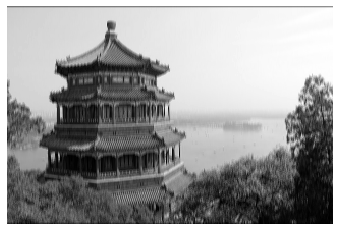

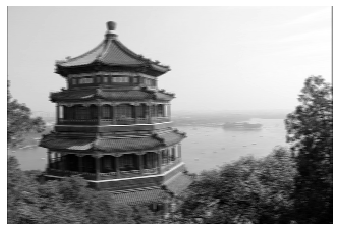

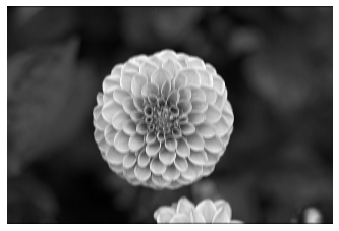

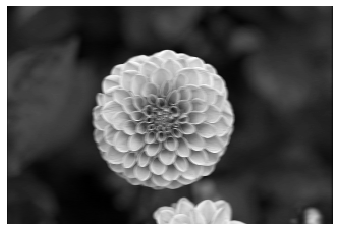

In [7]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

#### Usando tf.layers.conv2d()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


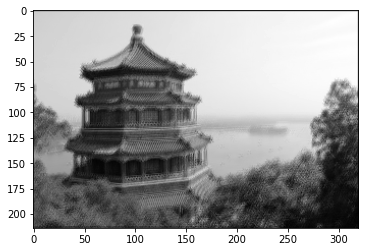

In [8]:
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.compat.v1.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding='SAME')

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})
    
plt.imshow(output[0, :, :, 1], cmap='gray') #plot do segundo mapa de recursos da 1ª imagem
plt.show()

### Camada de poling

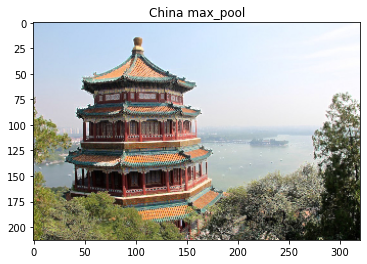

In [9]:
tf.compat.v1.reset_default_graph()

batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

X = tf.compat.v1.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding='VALID')

with tf.compat.v1.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))
plt.title('China max_pool')
plt.show()

### Exercícios do capítulo

*7*

Exercício: Construa sua própria CNN e tente alcançar a maior precisão possível no MNIST.

In [10]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [11]:
height, width = 28, 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = 'SAME'
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

tf.compat.v1.reset_default_graph()

with tf.name_scope('inputs'):
    X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs], name='X')
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.compat.v1.placeholder(tf.int32, shape=[None], name='y')
    training = tf.compat.v1.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.compat.v1.layers.conv2d(X_reshaped, 
                         filters=conv1_fmaps, 
                         kernel_size=conv1_ksize, 
                         strides=conv1_stride, 
                         padding=conv1_pad, 
                         activation=tf.nn.relu, 
                         name='conv1')

conv2 = tf.compat.v1.layers.conv2d(conv1, 
                         filters=conv2_fmaps, 
                         kernel_size=conv2_ksize, 
                         strides=conv2_stride, 
                         padding=conv2_pad, 
                         activation=tf.nn.relu, 
                         name='conv2')

with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.compat.v1.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope('fc1'):
    fc1 = tf.compat.v1.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.compat.v1.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.compat.v1.layers.dense(fc1_drop, n_outputs, name='output')
    Y_proba = tf.nn.softmax(logits, name='Y_proba')

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.compat.v1.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(y, logits, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope('init_and_save'):
    init = tf.compat.v1.global_variables_initializer()
    saver = tf.compat.v1.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [14]:
def get_model_params():
    gvars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.compat.v1.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.compat.v1.get_default_graph().get_operation_by_name(gvar_name + '/Assign') 
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.compat.v1.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [ ]:
n_epochs = 1000
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.compat.v1.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print('Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}'.format(epoch, 
                                                                                                                  acc_batch * 100, 
                                                                                                                  acc_val * 100, 
                                                                                                                  best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print('Early stopping!')
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print('Final accuracy on test set:', acc_test)
    save_path = saver.save(sess, 'models/my_mnist_model')

Epoch 0, last batch accuracy: 98.0000%, valid. accuracy: 98.4400%, valid. best loss: 0.057204
Epoch 1, last batch accuracy: 100.0000%, valid. accuracy: 98.4600%, valid. best loss: 0.043399
Epoch 2, last batch accuracy: 100.0000%, valid. accuracy: 98.8600%, valid. best loss: 0.040950
Epoch 3, last batch accuracy: 100.0000%, valid. accuracy: 99.0000%, valid. best loss: 0.036462
Epoch 4, last batch accuracy: 100.0000%, valid. accuracy: 98.9000%, valid. best loss: 0.035908
Epoch 5, last batch accuracy: 100.0000%, valid. accuracy: 99.0400%, valid. best loss: 0.035908
Epoch 6, last batch accuracy: 100.0000%, valid. accuracy: 99.1000%, valid. best loss: 0.035908
Epoch 7, last batch accuracy: 100.0000%, valid. accuracy: 99.1600%, valid. best loss: 0.035908
Epoch 8, last batch accuracy: 100.0000%, valid. accuracy: 99.0200%, valid. best loss: 0.031778
Epoch 9, last batch accuracy: 100.0000%, valid. accuracy: 99.0600%, valid. best loss: 0.031778
Epoch 10, last batch accuracy: 100.0000%, valid. ac